# Tutorial - Axial pile capacity calculation according to API RP2 GEO with groundhog

At the request of users, a routine for axial capacity is developed within groundhog.

The pile capacity class ``AxCapCalculation`` develops a workflow in which the unit skin friction methods and unit end bearing methods are introduced into a ``SoilProfile`` object.

A check is then performed to assess whether the necessary soil parameters are defined in the ``SoilProfile``. If all necessary parameters are available, a calculation grid is defined and the unit skin friction and unit end bearing calculations are calculated. This notebook outlines the different components of the calculation for the API RP2 GEO Main Text method.

## Library imports



In [42]:
import numpy as np

In [43]:
import plotly.io as pio
pio.templates.default = 'plotly_white'

In [44]:
from groundhog.general.soilprofile import SoilProfile
from groundhog.general.plotting import LogPlot

## Preparing a ``groundhog`` ``SoilProfile`` object for axial capacity analysis

### Definition of methods and soil parameters in ``SoilProfile``

For each layer in the ``SoilProfile``, the unit skin friction and unit end bearing need to be set. Each methods has associated required parameters. The presence of these parameters can be checked before starting the calculation.

First, a basic soil profile with three layers is defined:

In [99]:
sp = SoilProfile({
    'Depth from [m]': [0, 10],
    'Depth to [m]': [10, 40],
    'Soil type': ['Sand', 'Clay'],
    'Total unit weight [kN/m3]': [20, 18]
})
sp

,Depth from [m],Depth to [m],Soil type,Total unit weight [kN/m3]
0,0,10,Sand,20
1,10,40,Clay,18


Next, the calculation methods for unit skin friction and unit end bearing are specified in the columns ``Unit skin friction`` and ``Unit end bearing``.

In [100]:
sp['Unit skin friction'] = ['API RP2 GEO Sand', 'API RP2 GEO Clay']
sp['Unit end bearing'] = ['API RP2 GEO Sand', 'API RP2 GEO Clay']
sp

,Depth from [m],Depth to [m],Soil type,Total unit weight [kN/m3],Unit skin friction,Unit end bearing
0,0,10,Sand,20,API RP2 GEO Sand,API RP2 GEO Sand
1,10,40,Clay,18,API RP2 GEO Clay,API RP2 GEO Clay


### Overburden calculation

As several method require the vertical effective stress as an input, the stresses can be calculated using the ``calculate_overburden`` method.

In [101]:
sp.calculate_overburden()

The vertical effective stress profile can be plotted:

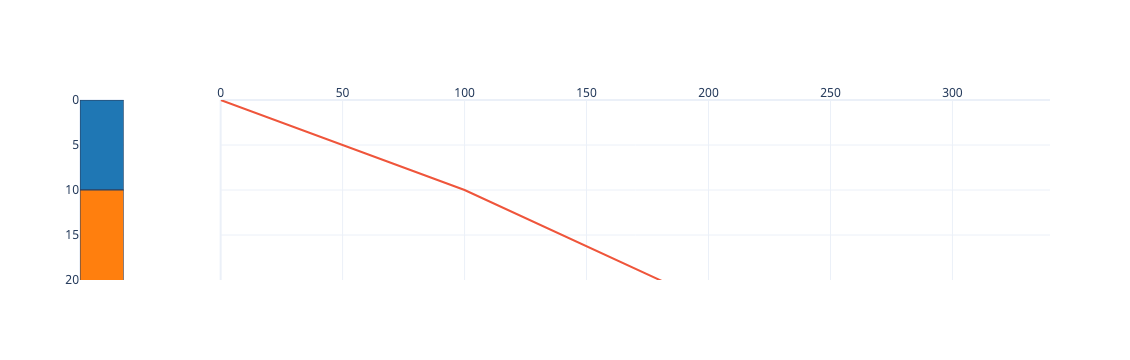

In [102]:
stress_plot = LogPlot(sp, no_panels=1, fillcolordict={'SAND': 'yellow', 'CLAY': 'brown'})
stress_plot.add_trace(
    x=sp.soilparameter_series('Vertical effective stress [kPa]')[1],
    z=sp.soilparameter_series('Vertical effective stress [kPa]')[0],
    name=r'$ \sigma_{v0}^{\prime} $', showlegend=False, panel_no=1)
stress_plot.set_xaxis(title=r'$ \sigma_{v0}^{\prime} \ \text{[kPa]} $', panel_no=1)
stress_plot.set_zaxis(title=r'$ z \ \text{[m]} $', range=(20, 0))
stress_plot.show()

## Axial pile capacity calculation setup

### Creating the calculation object

An axial capacity calculation can be set up based on the soil profile. The ``AxcapCalculation`` class contains the necessary functionality.

In [103]:
from groundhog.deepfoundations.axialcapacity.axcap import AxCapCalculation

In [104]:
calc = AxCapCalculation(sp)

### Checking of presence of require soil parameters

The presence of the required input to unit skin friction and unit end bearing calculations can be checked. Note that both numerical and string soil parameters need to be checked:

In [105]:
from groundhog.general.parameter_mapping import SOIL_PARAMETER_MAPPING, reverse_dict
from groundhog.deepfoundations.axialcapacity.skinfriction import SKINFRICTION_PARAMETERS, SKINFRICTION_METHODS
from groundhog.deepfoundations.axialcapacity.endbearing import ENDBEARING_PARAMETERS, ENDBEARING_METHODS

``groundhog`` has a standard mapping for soil parameters, which defines the mapping from column headers in a Pandas dataframe to ``groundhog`` function variables. Column headers must conform to this naming.

In [106]:
SOIL_PARAMETER_MAPPING

{'qc [MPa]': 'qc',
 'fs [MPa]': 'fs',
 'u2 [MPa]': 'u2',
 'qt [MPa]': 'qt',
 'ft [MPa]': 'ft',
 'qnet [MPa]': 'qnet',
 'Vertical total stress [kPa]': 'sigma_vo',
 'Vertical effective stress [kPa]': 'sigma_vo_eff',
 'Effective pressure [kPa]': 'p_eff',
 'Effective unit weight [kN/m3]': 'gamma_eff',
 'Total unit weight [kN/m3]': 'gamma_tot',
 'Unit weight [kN/m3]': 'gamma',
 'Ic [-]': 'ic',
 'Dr [-]': 'relative_density',
 'Gmax [kPa]': 'gmax',
 'G [kPa]': 'shearmodulus',
 'Qt [-]': 'Qt',
 'Bq [-]': 'Bq',
 'Fr [%]': 'Fr',
 'Rf [%]': 'Rf',
 'K0 [-]': 'k0',
 'Vs [m/s]': 'Vs',
 'gamma [kN/m3]': 'gamma',
 'OCR [-]': 'ocr',
 'PI [%]': 'pi',
 'z [m]': 'depth',
 'Embedded length [m]': 'embedded_length',
 'Effective friction angle [deg]': 'phi_eff',
 'Friction angle [deg]': 'phi',
 'Critical state friction angle [deg]': 'phi_cs',
 'Cohesion [kPa]': 'cohesion',
 'Minor principal stress [kPa]': 'sigma_3',
 'Major principal stress [kPa]': 'sigma_1',
 'Interface friction angle [deg]': 'interface_fric

The necessary parameters for skin friction calculation can be printed. In v0.9.0, only the API RP2 GEO methods are defined with their associated parameters.

In [107]:
SKINFRICTION_PARAMETERS

{'API RP2 GEO Sand': ['api_relativedensity',
  'api_soildescription',
  'sigma_vo_eff'],
 'API RP2 GEO Clay': ['undrained_shear_strength', 'sigma_vo_eff'],
 'Alm and Hamre Sand': ['qt',
  'sigma_vo_eff',
  'interface_friction_angle',
  'depth',
  'embedded_length'],
 'Alm and Hamre Clay': ['depth',
  'embedded_length',
  'qt',
  'fs',
  'sigma_vo_eff']}

With the method ``check_methods``, the presence of the parameters can be checked. At this point, the parameters are not yet defined so the method will return a message that the required parameters are not found.

In [108]:
calc.check_methods()

Skin friction method API RP2 GEO Sand: Required parameter API relative density description not found
Skin friction method API RP2 GEO Sand: Required parameter API soil description not found
Skin friction method API RP2 GEO Clay: Required parameter Undrained shear strength [kPa] not found
End bearing method API RP2 GEO Sand: Required parameter API relative density description not found
End bearing method API RP2 GEO Sand: Required parameter API soil description not found
End bearing method API RP2 GEO Clay: Required parameter Undrained shear strength [kPa] not found


The required soil parameters can be defined. Example parameters are defined below. The documentation of the unit skin friction and unit end bearing methods can be checked in the ``groundhog`` documentation.

In [109]:
calc.sp['API soil description'] = ['Sand', 'Clay']
calc.sp['API relative density description'] = ['Medium dense', '-']
calc.sp['Undrained shear strength from [kPa]'] = [np.nan, 150]
calc.sp['Undrained shear strength to [kPa]'] = [np.nan, 200]

In [110]:
for i, row in calc.sp.iterrows():
    if row['API relative density description'] == 'Very loose':
        calc.sp.loc[i, 'Dr [pct]'] = 10
    elif row['API relative density description'] == 'Loose':
        calc.sp.loc[i, 'Dr [pct]'] = 25
    elif row['API relative density description'] == 'Medium dense':
        calc.sp.loc[i, 'Dr [pct]'] = 50
    elif row['API relative density description'] == 'Dense':
        calc.sp.loc[i, 'Dr [pct]'] = 75
    elif row['API relative density description'] == 'Very dense':
        calc.sp.loc[i, 'Dr [pct]'] = 90
    else:
        calc.sp.loc[i, 'Dr [pct]'] = np.nan

When re-running the ``check_methods`` no messages are returned. But the attribute ``checked`` is now ``True``.

In [111]:
calc.check_methods()
calc.checked

True

## Gridding for axial capacity calculation

A calculation grid can be created based on the soil profile with a spacing of 1m.

In [112]:
calc.create_grid(dz=1)

The grid has a ``nodes`` and ``elements`` attribute where the former contains the nodal coordinates and the associated parameter values at the nodes. The latter contains the element definition with the parameter values at the center of the element.

In [113]:
calc.grid.nodes.head()

,z [m],Soil type,Unit skin friction,Unit end bearing,API soil description,API relative density description,Total unit weight [kN/m3],Water unit weight [kN/m3],Effective unit weight [kN/m3],Hydrostatic pressure [kPa],Vertical effective stress [kPa],Vertical total stress [kPa],Undrained shear strength [kPa],Dr [pct]
0,0.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense,20.0,10.0,10.0,0.0,0.0,0.0,NaN,50.0
1,1.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense,20.0,10.0,10.0,10.0,10.0,20.0,NaN,50.0
2,2.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense,20.0,10.0,10.0,20.0,20.0,40.0,NaN,50.0
3,3.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense,20.0,10.0,10.0,30.0,30.0,60.0,NaN,50.0
4,4.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense,20.0,10.0,10.0,40.0,40.0,80.0,NaN,50.0


In [114]:
calc.grid.elements.head()

,Depth from [m],Depth to [m],z [m],dz [m],Total unit weight [kN/m3],Water unit weight [kN/m3],Effective unit weight [kN/m3],Hydrostatic pressure from [kPa],Hydrostatic pressure to [kPa],Hydrostatic pressure [kPa],...,Vertical total stress [kPa],Undrained shear strength from [kPa],Undrained shear strength to [kPa],Undrained shear strength [kPa],Dr [pct],Soil type,Unit skin friction,Unit end bearing,API soil description,API relative density description
0,0.0,1.0,0.5,1.0,20.0,10.0,10.0,0.0,10.0,5.0,...,10.0,NaN,NaN,NaN,50.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense
1,1.0,2.0,1.5,1.0,20.0,10.0,10.0,10.0,20.0,15.0,...,30.0,NaN,NaN,NaN,50.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense
2,2.0,3.0,2.5,1.0,20.0,10.0,10.0,20.0,30.0,25.0,...,50.0,NaN,NaN,NaN,50.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense
3,3.0,4.0,3.5,1.0,20.0,10.0,10.0,30.0,40.0,35.0,...,70.0,NaN,NaN,NaN,50.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense
4,4.0,5.0,4.5,1.0,20.0,10.0,10.0,40.0,50.0,45.0,...,90.0,NaN,NaN,NaN,50.0,Sand,API RP2 GEO Sand,API RP2 GEO Sand,Sand,Medium dense


The parameters in the grid can be prepared for plotting by applying the ``soilparameter_series`` with the name of the parameter under consideration. The x- and z-values can be defined based on the parameter name.

In [115]:
su_z, su_x = calc.grid.soilparameter_series('Undrained shear strength [kPa]')
Dr_z, Dr_x = calc.grid.soilparameter_series('Dr [pct]')
sigmav_z, sigmav_x = calc.grid.soilparameter_series('Vertical effective stress [kPa]')

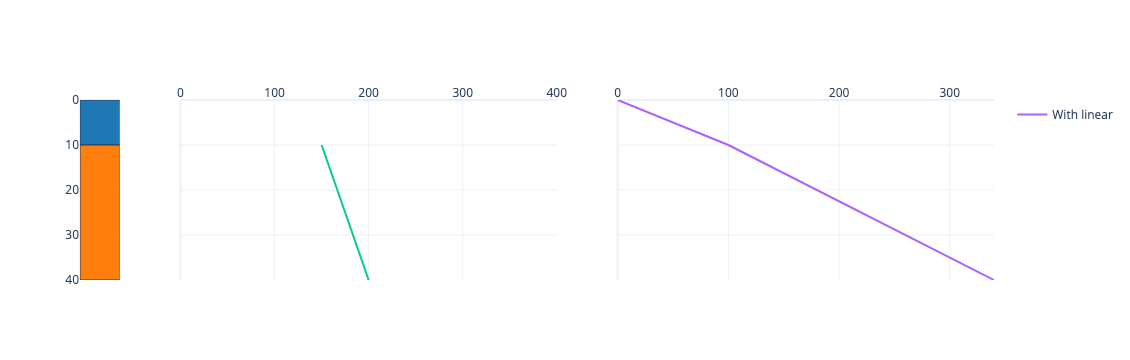

In [116]:
parameter_plot = LogPlot(calc.sp, no_panels=2, fillcolordict={'SAND': 'blanchedalmond', 'CLAY': 'wheat'})

parameter_plot.add_trace(x=su_x, z=su_z, showlegend=False, mode='lines',name='Su', panel_no=1)
parameter_plot.add_trace(x=sigmav_x, z=sigmav_z, showlegend=True, mode='lines',name='With linear', panel_no=2)

parameter_plot.set_xaxis(title=r'$ \sigma_{vo}^{\prime} \ \text{[kPa]} $', panel_no=2, range=(0, sigmav_x.max()))
parameter_plot.set_xaxis(title=r'$ S_u \ \text{[kPa]} $', panel_no=1, range=(0, 400))
parameter_plot.set_zaxis(title=r'$ z \ \text{[m]}$')
parameter_plot.show()

## Calculation of unit skin friction and unit end bearing

Unit skin friction and unit end bearing can be calculated by running the functions for the selected methods at each element.

Note that the unit skin friction distribution may be depth-dependent, so at this stage, the pile penetration will need to be introduced.

### Setting the pile penetration

The pile penetration can be set with the ``set_pilepenetration`` method. In this example, a pile penetration of 18m is selected.

In [117]:
calc.set_pilepenetration(30)

### Calculation of unit skin friction

For the calculation of unit skin friction, the equation for the selected method is applied for each element.

In [118]:
calc.calculate_unitskinfriction()

### Calculation of unit end bearing

Similarly, the unit end bearing can be calculated:

In [119]:
calc.calculate_unitendbearing()

### Unit skin friction and unit end bearing visualisation

The unit skin friction and unit end bearing profile can be visualised with the ``groundhog`` ``LogPlot``.

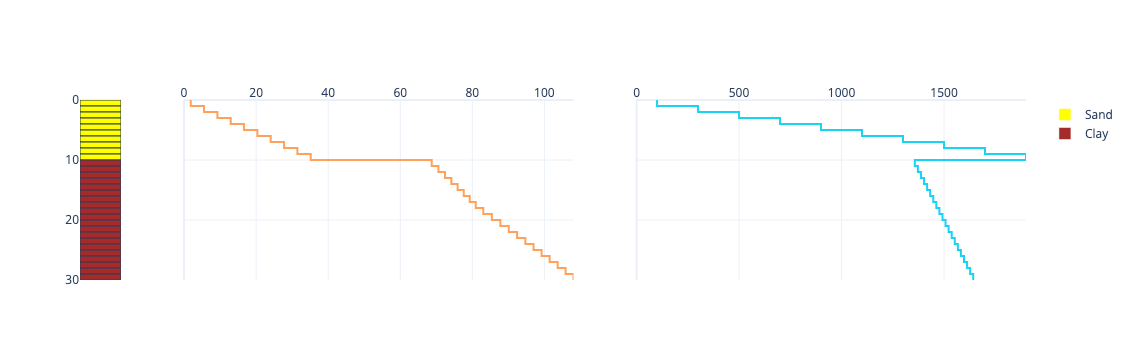

In [121]:
z_fs, x_fs = calc.output.soilparameter_series('Unit skin friction outside compression [kPa]')
z_qb, x_qb = calc.output.soilparameter_series('Unit end bearing plugged [kPa]')

fs_qb_plot = LogPlot(calc.output, no_panels=2, fillcolordict={'Sand': 'yellow', 'Clay': 'brown'})

fs_qb_plot.add_trace(x=x_fs, z=z_fs, showlegend=False, mode='lines',name='fs comp', panel_no=1)
fs_qb_plot.add_trace(x=x_qb, z=z_qb, showlegend=False, mode='lines',name='qb', panel_no=2)

fs_qb_plot.set_xaxis(title=r'$ q_b \ \text{[kPa]} $', panel_no=2, range=(0, x_qb.max()))
fs_qb_plot.set_xaxis(title=r'$ f_s \ \text{[kPa]} $', panel_no=1, range=(0, x_fs.max()))
fs_qb_plot.set_zaxis(title=r'$ z \ \text{[m]}$')
fs_qb_plot.show()

## Integration of unit skin friction and unit end bearing

Unit skin friction can be integrated over the annulus of the pile. Four modes are discerned:

   - Plugged compression: Outside skin friction and end bearing over the full diameter of the pile
   - Plugged tension: Outside skin friction in tension + weight of the pile material and/or internal soil plug
   - Coring compression: Outside skin friction + inside skin friction + annular end bearing
   - Coring tension: Outside skin friction in tension + inside skin friction in tension
   
The pile circumference and base cross-sectional area need to be known. Because pile shapes and sizes may differ, the weight of the pile and/or internal soil plug is excluded from the assessment. Calculating this component with a separate calculation is straightforward.

In this example, a tubular open-ended pile with 2.48m outer diameter and 50mm wall thickness is taken.

In [122]:
calc.calculate_pilecapacity(
    circumference=np.pi * 2.48, base_area=0.25 * np.pi * 2.48 ** 2,
    internal_circumference=np.pi * 2.38, annulus_area=0.25 * np.pi * (2.48 ** 2 - 2.38 ** 2))

In [124]:
calc.output.head()

,Depth from [m],Depth to [m],z [m],dz [m],Total unit weight [kN/m3],Water unit weight [kN/m3],Effective unit weight [kN/m3],Hydrostatic pressure from [kPa],Hydrostatic pressure to [kPa],Hydrostatic pressure [kPa],...,Unit skin friction inside tension [kPa],Unit end bearing plugged [kPa],Unit end bearing coring [kPa],Fs compression outside [kN],Fs tension outside [kN],Fs compression inside [kN],Fs tension inside [kN],Qb plugged [kN],Qb coring [kN],Qb internal [kN]
0,0.0,1.0,0.5,1.0,20.0,10.0,10.0,0.0,10.0,5.0,...,1.85,100.0,100.0,14.413627,14.413627,13.832432,13.832432,483.051286,38.170351,444.880936
1,1.0,2.0,1.5,1.0,20.0,10.0,10.0,10.0,20.0,15.0,...,5.55,300.0,300.0,57.654508,57.654508,55.329730,55.329730,1449.153859,114.511052,1334.642807
2,2.0,3.0,2.5,1.0,20.0,10.0,10.0,20.0,30.0,25.0,...,9.25,500.0,500.0,129.722644,129.722644,124.491892,124.491892,2415.256432,190.851754,2224.404678
3,3.0,4.0,3.5,1.0,20.0,10.0,10.0,30.0,40.0,35.0,...,12.95,700.0,700.0,230.618034,230.618034,221.318919,221.318919,3381.359005,267.192455,3114.166550
4,4.0,5.0,4.5,1.0,20.0,10.0,10.0,40.0,50.0,45.0,...,16.65,900.0,900.0,360.340677,360.340677,345.810811,345.810811,4347.461578,343.533157,4003.928421


### Results for the final penetration

As unit skin friction profiles can be penetration-dependent, the plot of unit skin friction $ f_s $ is only valid for the selected final pile penetration.

The profiles of unit skin friction $ f_s $, unit end bearing $ q_b $ and integrated shaft resistance in compression and tension over the inside and outside of the pile are plotted as well as the plugged and unplugged (coring) end bearing.

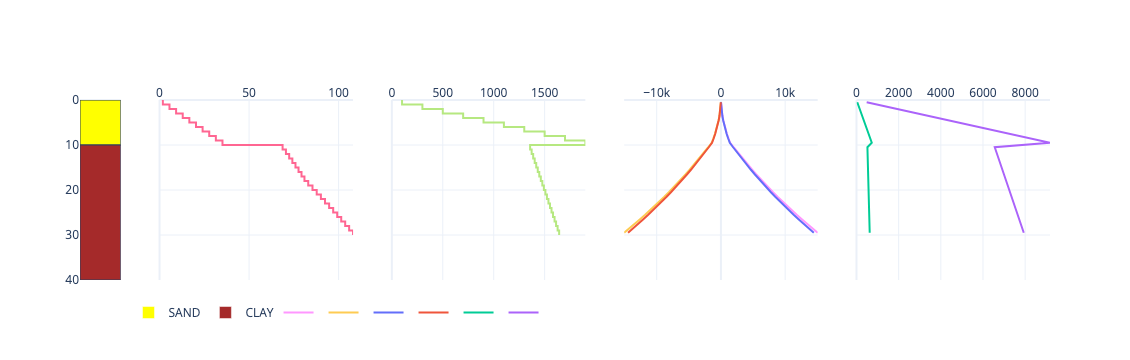

In [98]:
calc.plot_single_penetration()

Numerical values of the results are available in the ``result`` attribute. These values are valid for the final pile penetration.

In [135]:
import pandas as pd
pd.DataFrame.from_dict([calc.result])

,Rs compression plugged [kN],Rb plugged [kN],Rs compression coring [kN],Rb coring [kN],Rb internal [kN],Rt compression plugged [kN],Rt compression coring [kN],Rt compression [kN],Plugged compression,Rs tension plugged [kN],Rs tension coring [kN],Pile weight [kN],Soil plug weight [kN],Rt tension plugged [kN],Rt tension coring [kN],Rt tension [kN],Plugged tension
0,15063.689292,7934.117379,29519.971758,626.948011,7307.169368,22997.806672,30146.919769,22997.806672,True,15063.689292,29519.971758,0,0,15063.689292,29519.971758,15063.689292,True


### Results for all penetrations

The calculation of axial pile capacity needs to be repeated for every pile penetration for pile sizing as unit skin friction and unit end bearing can be depth-dependent (e.g. due to friction fatigue).

In [ ]:
calc.calculate_capacity_profile(
    circumference=np.pi * 2.48, base_area=0.25 * np.pi * 2.48 ** 2,
    internal_circumference=np.pi * 2.38, annulus_area=0.25 * np.pi * (2.48 ** 2 - 2.38 ** 2),
    pile_weight_permeter=0.25 * np.pi * (2.48 ** 2 - 2.38 ** 2) * 68.5,
    soilplug_weight_permeter=0.25 * np.pi * 2.38 ** 2 * 10)

The results can be visualised. The leftmost panel shows the shaft resistance in compression and tension for plugged (only outside) and coring (inside and outside) conditions. The coring and plugged base resistance are shown in the middle panel. In the right-most panel, the compression and tension resistance for plugged and coring conditions are shown. Depending on the relative magnitude of internal shaft resistance vs end bearing on the plug, the calculation selects whether plugged (internal shaft resistance > end bearing on soil plug) or coring (internal shaft resistance < end bearing on soil plug) conditions are expected.

In [ ]:
calc.plot_all_penetrations()

The results are shown in a dataframe which can be exported to csv or Excel.

In [ ]:
calc.capacity_profile.head()